"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

**Introduction**

Transforming Data:

In [1]:
!pip install gradpyent

In [2]:
import utilsmathsem as mathsem
import pandas as pd
import openpyxl

df = pd.read_excel('/kaggle/input/data-for-mathsem/QLA.xlsx')
df.head()

,Name,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q9,Q10,Q11,Q12,Q13a,Q13b
0,Alpha,1,1,1,2,2,2,2,2,1,2,1,0,0
1,Bravo,1,1,0,2,0,0,0,0,1,0,0,0,0
2,Charlie,0,0,0,1,1,0,1,0,0,1,0,0,0
3,Delta,1,1,0,2,1,2,2,1,2,1,1,0,0
4,Echo,1,1,1,2,2,0,2,1,1,1,0,0,0


Explain what a QLA is...

In [3]:
questions = mathsem.get_questions(df)
students = mathsem.get_students(df)
mark_dictionary, marks = mathsem.get_marks(df, questions)

#Transforming data
score_data = mathsem.get_score_df(df)
skill_data = mathsem.get_skill_df(df,5)



Description

Using pre-made datasets

In [4]:
skill_data = pd.read_excel('/kaggle/input/data-for-mathsem/Skill Data.xlsx')
all_skills, skill_dict = mathsem.skills(skill_data)
skillinfo_data = mathsem.pd.read_excel('/kaggle/input/data-for-mathsem/Skill Info.xlsx')
skill_tags = mathsem.get_skilltags(skillinfo_data)

Discuss EM and present it here:

In [5]:
def optimise(start_val, tolerance):
    theta = mathsem.theta_0(marks, start_val) #Returns an array of start values of length of marks
    logl = 0
    logl_list = []
    for iter in range(1, 1000):
        logl_prev = logl
        posteriors, pcomp, signals, logl = mathsem.e_step(theta, students, score_data, skill_data, mark_dictionary)
        theta = mathsem.m_step(pcomp, signals, marks)
        print(f'Iteration {iter}: Log Liklelihood = {logl}')
        logl_list.append([iter, logl])
        if iter > 2:
            step_change = logl - logl_prev
            if -step_change < tolerance:
                print("Optimisation Complete")
                return posteriors, theta, logl_list

posteriors, theta, logl_list = optimise(0.75, 0.1)

Iteration 1: Log Liklelihood = 259.75389164181854
Iteration 2: Log Liklelihood = 226.79634118303244
Iteration 3: Log Liklelihood = 222.06331604200048
Iteration 4: Log Liklelihood = 220.78256729191307
Iteration 5: Log Liklelihood = 220.11051071907804
Iteration 6: Log Liklelihood = 219.66225329272504
Iteration 7: Log Liklelihood = 219.33747707671728
Iteration 8: Log Liklelihood = 219.0944599633139
Iteration 9: Log Liklelihood = 218.91024833861846
Iteration 10: Log Liklelihood = 218.7695526098932
Iteration 11: Log Liklelihood = 218.66114462650728
Iteration 12: Log Liklelihood = 218.57660187122795
Optimisation Complete


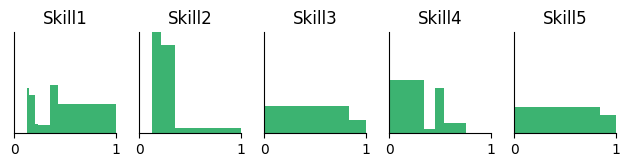

In [6]:
fig = mathsem.display_skilldist(posteriors, 'Bravo', all_skills)
fig.show()

In [7]:
import plotly.graph_objects as go
import numpy as np

def create_radar_chart(student):
    posterior = posteriors[student] #Take student's posterior distribution for posteriors dictionary
    expectations = mathsem.get_expectations(posterior, all_skills)
    scaler = 1/np.max(expectations) #scale expectations
    scaled_expectations = expectations*scaler

    fig = go.FigureWidget(data=[go.Scatterpolar(
        r=[1, 1, 1, 1, 1],
        theta=['Skill '+str(skill) for skill in all_skills],
        fill='toself',
        fillcolor='lightgrey',
        line_color='white',
        opacity=0.4
        )])
    
    fig.add_trace(go.Scatterpolar(
        r=scaled_expectations.tolist(),
        theta=['Skill '+str(skill) for skill in all_skills],
        fill='toself',
        fillcolor='plum',
        line_color='plum',
        opacity = 1,
        marker = dict(opacity=0)
        ))
    
    fig.update_layout(
        polar=(dict(
            radialaxis=dict(showline=False,
                           showgrid=False,
                           showticklabels=False,
                           ticks=''),
            angularaxis=dict(showline=False,
                           showgrid=False,
                           ticks=''),
            bgcolor='white',
            )),
        showlegend=False,
        width = 350,
        height = 350,
        margin = dict(l=40, r=40, t=40, b=40),
        title = dict(
            text="Skill Map",
            x=0.5,
            xanchor='center'
            )
        )
    
    return fig

radar_chart = create_radar_chart('Bravo')
radar_chart.show()

Strenght data

In [8]:
strength_list = []
for student in students:
    strength_list.append(mathsem.get_expectations(posteriors[student], all_skills))
strength_data = pd.DataFrame(np.array(strength_list), columns=all_skills)
strength_data.index = students
strength_data.head()

,1,2,3,4,5
Alpha,0.668403,0.629838,0.645296,0.877701,0.421260
Bravo,0.573079,0.299905,0.460502,0.272226,0.478837
Charlie,0.062171,0.664468,0.468398,0.189746,0.486483
Delta,0.580647,0.672270,0.402940,0.877701,0.415064
Echo,0.688201,0.677345,0.298076,0.633735,0.424309


Lim data

In [9]:
def get_lim_df(mode, scale):
    thresh_array = mathsem.thresharray(skill_dict, all_skills) 
    all_lim_array = []

    for student in students:
        scores = mathsem.student_scores(score_data, student)
        signals = mathsem.student_sigs(score_data, mark_dictionary, student)
        student_lim_array, skill_usage = mathsem.plimit(thresh_array, posteriors[student], all_skills, theta, scores, signals)
        if mode == 1:
            student_lim = np.mean(student_lim_array, axis=0)
        elif mode == 0:
            student_lim = np.sum(student_lim_array, axis=0)/skill_usage
        else:
            raise ValueError('Mode needs to be either 1 or 0')
        
        all_lim_array.append(student_lim)

    all_lim_array = np.array(all_lim_array)
    n_ik = len(students) * len(all_skills)
    beta = np.prod(all_lim_array) ** (-1/(scale*n_ik))
    all_lim_array = np.emath.logn(beta, all_lim_array)
    all_lim_array[all_lim_array < -1] = -1
    all_lim_array *= -1
    lim_df = pd.DataFrame(all_lim_array, columns=all_skills)
    lim_df.index = students
    return lim_df

mode = 1
scale = 1
lim_data = get_lim_df(mode, scale)
lim_data.head()

,1,2,3,4,5
Alpha,0.556143,0.666259,0.236507,1.000000,0.314353
Bravo,1.000000,0.516727,0.557137,0.372089,0.645109
Charlie,0.281523,1.000000,0.653695,0.403055,0.735369
Delta,0.537358,0.950864,0.355294,1.000000,0.489769
Echo,1.000000,1.000000,0.298050,0.622270,0.494423


Clustering

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def gen_clusters(df):
    pca = PCA(n_components = 2)
    lim_principal = pca.fit_transform(df)
    lim_principal = pd.DataFrame(lim_principal)

    k_range = range(2, 10)
    s_scores = []
    for k in k_range:
        s_scores.append(
            silhouette_score(lim_principal, AgglomerativeClustering(n_clusters=k, metric='euclidean').fit_predict(lim_principal))
            )
    top_score = -1
    for score in s_scores:
        if score > top_score:
            top_score = score
    clusters = k_range[s_scores.index(top_score)]
    
    agg = AgglomerativeClustering(n_clusters=clusters, metric='euclidean', linkage='average')
    hac = agg.fit(lim_principal)
    y_hac = hac.fit_predict(df)
    new_df = df.copy()
    new_df['Group'] = y_hac
    lim_principal['Group'] = y_hac
    pd.concat([new_df, lim_principal], axis=1)
    return new_df, lim_principal

lim_data_grouped, cluster_df = gen_clusters(strength_data)
mathsem.display_clusters(cluster_df)

Rag Data

In [11]:
from gradpyent.gradient import Gradient
def get_rag(lim):
    lim *= 2
    if float(lim) < 1:
        gradient_start, gradient_end = '#ff0000', '#ffc300'
    if float(lim) >= 1:
        lim -= 1
        gradient_start, gradient_end = '#ffc300', '#00ff00'

    gg = Gradient(gradient_start=gradient_start,gradient_end=gradient_end, opacity=1)
    return gg.get_gradient_series(series=[lim], fmt='html')[0]

print(get_rag(0.3))

rag_df = lim_data.copy()
rag_df.loc['Average'] = rag_df.mean(numeric_only=True)
rag_df = rag_df.map(get_rag)
rag_df.head()

#ff7500


,1,2,3,4,5
Alpha,#e2c900,#aad600,#ff5c00,#00ff00,#ff7a00
Bravo,#00ff00,#f6c500,#e1c900,#ff9100,#b4d400
Charlie,#ff6d00,#00ff00,#b0d500,#ff9d00,#86df00
Delta,#ebc700,#19f900,#ff8a00,#00ff00,#ffbf00
Echo,#00ff00,#00ff00,#ff7400,#c0d100,#ffc000


Dash

In [12]:
from ipywidgets import widgets
from IPython.display import display
from plotly.subplots import make_subplots

lim_or_str = widgets.Dropdown(
    options = ['Lim', 'Str'],
    value = 'Lim',
    description = 'Limited or Strength'
)

mode = widgets.Dropdown(
    options = [1, 0],
    value = 1,
    description = 'Mode'
)

scale = widgets.FloatSlider(
    value = 1,
    min = 0.1,
    max = 2,
    step = 0.1,
    description = 'Scale'
)

grouped = widgets.Checkbox(
    description = 'Grouped:',
    value = True
)

def get_rag_data(this_df):
    rag_df = this_df.copy()
    average = rag_df.mean(numeric_only=True)
    rag_df.loc['Average'] = average
    rag_df = rag_df.map(get_rag)
    values = [rag_df.index.values.tolist()] + [["" for i in range(len(rag_df.index.values.tolist()))] for skill in range(len(all_skills))]
    colours = [np.array(['white' for student in range(len(df))])] + [np.array(rag_df.iloc[:, i].tolist()) for i in range(len(all_skills))]
    return values, colours


output = widgets.Output()

def generate_figure(lim_or_str, mode, scale, grouped):
    if lim_or_str == 'Lim':
        raw_data = get_lim_df(mode, scale)
    else:
        raw_data = strength_data
    
    if grouped:
        total_height = 0
        raw_grouped_data = gen_clusters(raw_data)[0]
        groups = sorted(raw_grouped_data['Group'].unique())
        num_tables = len(groups)
        fig = make_subplots(
            rows = num_tables,
            cols = 1,
            specs=[[{"type": "table"}] for _ in range(num_tables)],
            subplot_titles = [f'Group {group+1}' for group in groups],
            vertical_spacing = 0.05
            )    
        
        for idx, group in enumerate(groups):
            grouped_data = raw_grouped_data[raw_grouped_data['Group'] == group].drop(columns='Group')
            vals, cols = get_rag_data(grouped_data)
            table = go.Table(
                columnwidth=[2,1,1,1,1,1],
                header = dict(values=['Student'] + [str(skill_tags[skill]) for skill in all_skills],
                              align = ['center'],
                              line_color='darkslategray'),
                cells = dict(values = vals,
                             fill_color = cols,
                             align = 'right',
                             line_color='darkslategray')
                )
            
            fig.add_trace(table, row=idx+1,col=1)
            fig.update_layout(
                margin=dict(l=100, r=100, t=30, b=0),
                height = 200*num_tables
            )
        
    else:
        vals, cols = get_rag_data(raw_data)
        fig = go.FigureWidget(data=[go.Table(
            columnwidth=[2,1,1,1,1,1],
            header = dict(values=['Student'] + [str(skill_tags[skill]) for skill in all_skills],
                          align = ['center'],
                          line_color='darkslategray'),
            cells = dict(values = vals,
                         fill_color = cols,
                         align = 'right',
                         line_color='darkslategray')
                         )
            ])
        
        fig.update_layout(
            height = 750,
            margin=dict(l=100, r=100, t=30, b=0)
        )

    fig.update_layout(
        showlegend=False,
        autosize = True
    )
    
    return fig


def update_figure(lim_or_str, mode, scale, grouped):
    with output:
        output.clear_output(wait=True)
        fig = generate_figure(lim_or_str, mode, scale, grouped)
        fig.show()

    
def update_control_visibility(lim_or_str):
    if lim_or_str == "Lim":
        mode.layout.visibility = 'visible'
        scale.layout.visibility = 'visible'
    else:
        mode.layout.visibility = 'hidden'
        scale.layout.visibility = 'hidden'
        
def update_lim_length(mode):
    if mode == 1:
        scale.max = 2
    else:
        scale.max = 8

        
lim_or_str.observe(lambda change: update_control_visibility(change.new), names='value')
mode.observe(lambda change: update_lim_length(change.new), names='value')
interactive_widgets = widgets.interactive(update_figure, 
    lim_or_str=lim_or_str, 
    mode=mode, 
    scale=scale, 
    grouped=grouped
)

title = widgets.HTML(value='<h2 style="font-size: 36px; text-align: center; color: black;">Student RAGs</h2>')
controls = widgets.VBox([lim_or_str, widgets.HBox([grouped, mode, scale])])
display(controls, title, output)


#Initialise a plot
update_figure(lim_or_str.value, mode.value, scale.value, grouped.value)

HTML(value='<h2 style="font-size: 36px; text-align: center; color: black;">Student RAGs</h2>')

Output()

Student Dash

In [13]:
from ipywidgets import widgets, Layout
from IPython.display import display
from plotly.subplots import make_subplots

def get_rag_data_i(stu, mode, scale):
    thresh_array = mathsem.thresharray(skill_dict, all_skills)
    scores = mathsem.student_scores(score_data, stu)
    signals = mathsem.student_sigs(score_data, mark_dictionary, stu)
    stu_lim_array, skill_usage = mathsem.plimit(thresh_array, posteriors[stu], all_skills, theta, scores, signals)
    if mode == 1:
            lim = np.mean(stu_lim_array, axis=0)
    if mode == 0:
        lim = np.sum(stu_lim_array, axis=0)/skill_usage
    beta = np.prod(lim) ** (-1/(scale*len(all_skills)))
    lim = np.emath.logn(beta, lim)
    lim[lim < -1] = -1
    lim *= -1
    rag_i = []
    for li in lim:
        rag_i.append(get_rag(li))
    rag_i = np.array(rag_i)
    values = [[str(skill) for skill in all_skills], [str(skill_tags[skill]) for skill in all_skills], ["" for skill in all_skills]]
    colours = [np.array(['white' for skill in all_skills]), np.array(['white' for skill in all_skills]), rag_i]
    return values, colours



def generate_rag_table(stu, mode, scale):
    vals, cols = get_rag_data_i(stu, mode, scale)
    fig = go.FigureWidget(data=[go.Table(
            columnwidth = [1.5, 7, 1],
            header = dict(values = ['Skill', 'Desc.', 'RAG'],
                         align = ['center'],
                         line_color='darkslategray',
                         fill_color='lavender'),
            cells = dict(values = vals,
                        fill_color = cols,
                        align = 'right',
                        line_color = 'darkslategray')
            )])
    fig.update_layout(
        title = dict(
            text="To Improve",
            x=0.5,
            xanchor='center',
        ),
        width = 350,
        height = 300,
        showlegend=False,
        autosize = True,
        margin = dict(l=30, r=30, t=30, b=30)
    )
    
    return fig

def generate_scoretable(stu):
    question_scores = df.loc[df["Name"] == stu].values.tolist()[0]
    question_scores.pop(0)
    question_totalmarks = df.loc[df["Name"] == "Total Marks"].values.tolist()[0]
    question_totalmarks.pop(0)
    
    fig = go.FigureWidget(data=[go.Table(
            columnwidth = [1.5, 7, 1, 1.5],
            header = dict(values = ['Question','Desc', 'Mark', 'Out of'],
                         align = ['left'],
                         line_color='darkslategray',
                         fill_color='lavender'),
            cells = dict(values = [questions, ["" for _ in range(len(questions))], question_scores, question_totalmarks],
                        align = 'left',
                        line_color = 'darkslategray',
                        fill_color='white')
        )])
    
    fig.update_layout(
    title = dict(
        text="Mark Breakdown",
        x=0.5,
        xanchor='center',
    ),
    width = 700,
    height = 350,
    margin = dict(l=30, r=30, t=30, b=30)
    )

    return fig


output_rag = widgets.Output()
def update_rag_table(stu, mode, scale):
    with output_rag:
        output_rag.clear_output(wait=True)
        fig_rag = generate_rag_table(stu, mode, scale)
        fig_rag.show()

output_radar = widgets.Output()
def update_radar_chart(stu):
    with output_radar:
        output_radar.clear_output(wait=True)
        fig_radar = create_radar_chart(stu)
        fig_radar.show()

output_scoretable = widgets.Output()
def update_scoretable(stu):
    with output_scoretable:
        output_scoretable.clear_output(wait=True)
        fig_scoretable = generate_scoretable(stu)
        fig_scoretable.show()
            
student = widgets.Dropdown(
    options = students,
    value = 'Alpha',
    description = 'Student',
    layout=Layout(width='200px')
)

mode2 = widgets.Dropdown(
    options = [1, 0],
    value = 1,
    description = 'Mode',
    layout=Layout(height='25px')
)

scale2 = widgets.FloatSlider(
    value = 1,
    min = 0.1,
    max = 2,
    step = 0.1,
    description = 'Scale',
    layout=Layout(height='25px')
)

def update_lim_length(mode):
    if mode == 1:
        scale2.max = 2
    else:
        scale2.max = 8

mode2.observe(lambda change: update_lim_length(change.new), names='value')

interactive_rag = widgets.interactive(update_rag_table, stu=student, mode=mode2, scale=scale2)
interactive_radar = widgets.interactive(update_radar_chart, stu=student)
interactive_scoretable = widgets.interactive(update_scoretable, stu=student)

controls_rag = widgets.VBox([mode2, scale2], layout=Layout(justify_content='flex-end'))
figures_controls = widgets.HBox([student, controls_rag], layout=Layout(justify_content='space-between'))
figures_row1 = widgets.HBox([output_radar, output_rag], layout=Layout(align_items='baseline', justify_content='space-around'))
figures_row2 = widgets.HBox([output_scoretable], layout=Layout(justify_content='center'))
title = widgets.HTML(value='<h2 style="font-size: 36px; text-align: center; color: black;">Feedback: Surds Test</h2>')

ui = widgets.VBox([figures_controls, title, figures_row1, figures_row2], layout=Layout(width='50%'))
display(ui)

#Initialise a plot
update_rag_table(student.value, mode2.value, scale2.value)
update_radar_chart(student.value)
update_scoretable(student.value)